## *PCFG* za *tRNK*<a id="par:toc"></a>

U radu je razmotrena primena [probabilističkih kontekstno slobodnih gramatika](https://en.wikipedia.org/wiki/Probabilistic_context-free_grammar) (*PCFG*) u predviđanju sekundarne strukture [transportne ribonukleinske kiseline](https://en.wikipedia.org/wiki/Transfer_RNA) (*tRNK*). Preuzet je [skup *tRNK* sa pridruženim strukturama](http://trna.bioinf.uni-leipzig.de/DataOutput/), nakon čega je na delu podataka obučeno nekoliko stohastičkih gramatika. Modeli su vrednovani prema ponašanju na drugom delu podataka, odnosno sličnosti predviđene strukture sa stvarnom. Upoređeni su kako međusobno, tako i sa [literaturom](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-5-71).

## Sadržaj

1. [Primarna struktura](#par:prim)
2. [Sekundarna struktura](#par:sekund)
3. [Gramatika *Nussinov*](#par:nuss)
4. [Gramatika *KH-99*](#par:kh99)
5. [Model kovarijacije](#par:kovar)
6. [Baza podataka *tRNAdb*](#par:trnadb)
7. [Konstrukcija modela](#par:konstr)
8. [Poređenje modela](#par:poredj)

## 1. Primarna struktura [⮭]<a id="par:prim"></a>

[⮭]: #par:toc

Sekundarnoj strukturi, naravno, prethodni [primarna](https://en.wikipedia.org/wiki/Nucleic_acid_sequence). *RNK* se najčešće predstavlja kao niska nad azbukom ribonukleotida $\{A, U, C, G\}$.

<img src='../slike/RNK.png' width='40%'>

Pored $A-U$ i $C-G$ prema [Votsonu i Kriku](https://en.wikipedia.org/wiki/Base_pair), zbog povoljne termodinamičke konfiguracije ponekad se uparuje i [nekanonski](https://en.wikipedia.org/wiki/Non-canonical_base_pairing) ([*wobble*](https://en.wikipedia.org/wiki/Wobble_base_pair)) par $U-G$.

In [1]:
# Azbuka ribonukleotida
A, U, C, G = 'AUCG'

# Pamćenje azbuke kao skupa
azbuka = {A, U, C, G}

# Moguća uparivanja ribonukleotida
parovi = [(A, U), (U, A), (C, G), (G, C), (U, G), (G, U)]

# Provera korektnosti uparivanja
def par(*rns):
    return rns in parovi

In [2]:
# Adenin se uparuje sa uracilom
par(A, U)

True

In [3]:
# Adenin se ne uparuje sa guaninon
par(A, G)

False

Specijalno, sekvencu mogu činiti i drugi karakteri, koji predstavljaju [modifikovane baze](https://en.wikipedia.org/wiki/Nucleobase#Modified_nucleobases). Na primer, pseudouridin (*P*) predstavlja izmenjeni uridin (*U*). Jednostavnosti radi, a usled ograničenja uparivanja koje sama sekundarna struktura nameće, ovakva modifikovanost može se slobodno zanemariti.

In [4]:
# Biblioteka za regularne izraze
import re

# Svođenje sekvence na četiri ribonukleotida
def standardizuj(sekvenca):
    # Standardizacija svih modifikacija adenina
    sekvenca = re.sub('[H"/+*=6E[:IO^`]', A, sekvenca)
    
    # Standardizacija svih modifikacija uracila
    sekvenca = re.sub(r'[tN{2J4&1S3V5!$X,)~DP\]ZTF\\]', U, sekvenca)
    
    # Standardizacija svih modifikacija citozina
    sekvenca = re.sub("[<%BM?'}>°]", C, sekvenca)
    
    # Standardizacija svih modifikacija guanina
    sekvenca = re.sub('[;KL#R|7(Q89YW]', G, sekvenca)
    
    # Vraćanje standardizovane sekvence
    return sekvenca

In [5]:
# Primer jedne nestandarnde sekvence
sekvenca1 = 'LUGJA4G'

# Standardizacija te sekvence
sekvenca2 = standardizuj('LUGJA4G')

# Prikaz obe verzije sekvence
sekvenca1, sekvenca2

('LUGJA4G', 'GUGUAUG')

Nakon standardizacije, sekvenca stvarno može sadržati samo četiri različita karaktera iz osnovnog skupa [ribonukleotida](https://en.wikipedia.org/wiki/Ribonucleotide), odnosno njegov je podskup.

In [6]:
# Provera da li je sekvenca korektna
def proveri_sekvencu(sekvenca):
    # Standardizacija ulazne sekvence
    sekvenca = standardizuj(sekvenca)
    
    # Provera da li je azbuka dobra
    return set(sekvenca) <= azbuka, sekvenca

In [7]:
# Korektna sekvenca
sekvenca1, proveri_sekvencu(sekvenca1)

('LUGJA4G', (True, 'GUGUAUG'))

In [8]:
# Nekorektna sekvenca
proveri_sekvencu('AUGC0')[0]

False

## 2. Sekundarna struktura [⮭]<a id="par:sekund"></a>

[⮭]: #par:toc

[Transportna *RNK*](https://en.wikipedia.org/wiki/Transfer_RNA) ima karakterističnu [sekundarnu strukturu](https://en.wikipedia.org/wiki/Nucleic_acid_secondary_structure) u obliku [deteline sa tri lista](https://en.wikipedia.org/wiki/Cloverleaf_model_of_tRNA). Listove (petlje, *loop*) čine neuparene baze, dok se kao veza između njih nalaze četiri zavojnice (drške, *stem*) i umetnuti nukleotidi. Na drugom [listu](https://en.wikipedia.org/wiki/Stem-loop), otprlike u sredini sekvence, nalazi se antikodon aminokiseline koja se prenosi.

<img src='../slike/tRNK.jpg' width='40%'>

I sekundarnu strukturu moguće je predstaviti kao nisku, i to nad azbukom koja se sastoji od [tačke i zagrada](https://eprints.soton.ac.uk/267292/1/RamlanEI08ExtDotBracRNA.pdf). U ovakvoj notaciji, tačka predstavlja neuparenu bazu, dok zagrade označavaju parove. Uparivanje baza, očekivano, prati matematičko i jezičko pravilo uparivanja zagrada, uz dodatni mininalni razmak.

In [9]:
# Azbuka strukture
zagrade = {'(', '.', ')'}

# Provera da li je struktura korektna
def proveri_strukturu(struktura, razmak=0):
    # Inicijalizacija uparivanja
    uparivanje = {}
    
    # Provera da li je azbuka dobra
    if not set(struktura) <= zagrade:
        return False, uparivanje
    
    # Inicijalizacija steka indeksa
    stek = []
    
    # Prolazak kroz celu strukturu
    for j, c in enumerate(struktura):
        # Stavljanje prvog člana uparivanja na stek
        if c == '(':          
            stek.append(j)
        
        # Provera da li je stek neprazan
        elif c == ')':
            if not stek:
                return False, uparivanje
            
            # Dohvatanje prvog člana uparivanja
            i = stek.pop()
            
            # Provera korektnosti razmaka uparivanja
            if j - i <= razmak:
                return False, uparivanje
            
            # Uparivanje prvog i drugog člana
            uparivanje[i] = j
    
    # Provera da li je stek prazan
    return not stek, uparivanje

In [10]:
# Korektna struktura
proveri_strukturu('.((..))')

(True, {2: 5, 1: 6})

In [11]:
# Nekorektna struktura: neuparene zagrade
proveri_strukturu('.(..))')[0]

False

In [12]:
# Nekorektna struktura: pogrešna azbuka
proveri_strukturu('.?')[0]

False

In [13]:
# Polukorektna struktura: mali razmak
proveri_strukturu('.((..))', 3)[0]

False

Podrazumevano, niske koje predstavljaju primarnu (sekvencu) i sekundarnu (uparivanje) strukturu iste *RNK* moraju biti saglasne.

In [14]:
# Provera saglasnosti sekvence i strukture
def proveri_uparenost(sekvenca, struktura, razmak=0, uparivanje=None):
    # Inicijalizacija mape broja parova
    uparenost = {rn_i: {rn_j: 0 for rn_j in azbuka} for rn_i in azbuka}
    
    # Sekvenca i struktura moraju biti iste dužine
    if len(sekvenca) != len(struktura):
        return False, uparenost
    
    # Određivanje uparivanja ukoliko nije poznato
    if uparivanje is None:
        ok, uparivanje = proveri_strukturu(struktura, razmak)
        
        # Provera da li je struktura dobra
        if not ok: return False, uparenost
    
    # Prolazak kroz sva uparivanja
    for i, j in uparivanje.items():
        rn_i = sekvenca[i]
        rn_j = sekvenca[j]
        
        # Nukleotidi moraju biti korektan par
        if not par(rn_i, rn_j):
            return False, uparenost
        
        # Uvećavanje brojača parova
        uparenost[rn_i][rn_j] += 1
    
    # Vraćanje mape broja parova
    return True, uparenost

In [15]:
# Primer sekvence
sekvenca = 'GUGUAUG'

# Korektna struktura
proveri_uparenost(sekvenca, '.((..))')

(True,
 {'U': {'U': 0, 'C': 0, 'G': 1, 'A': 0},
  'C': {'U': 0, 'C': 0, 'G': 0, 'A': 0},
  'G': {'U': 1, 'C': 0, 'G': 0, 'A': 0},
  'A': {'U': 0, 'C': 0, 'G': 0, 'A': 0}})

In [16]:
# Nekorektna struktura: par G-G
proveri_uparenost(sekvenca, '(.....)')[0]

False

In [17]:
# Nekorektna struktura: loša zagrada
proveri_uparenost(sekvenca, '(......')[0]

False

In [18]:
# Nekorektna struktura: loša dužina
proveri_uparenost(sekvenca, '(....)')[0]

False

Sa svime dosad iznesenim u vidu, moguće je definisati klasu koja predstavlja sekvencu sa pridruženom sekundarnom strukturom.

In [19]:
# Biblioteka za rad sa stablima
from nltk import Tree

# Biblioteka za crtanje
from ipynb.draw import draw_struct

# Primarna sekvenca sa pridruženom sekundarnom strukturom
class Struktura2D:
    def __init__(self, sekvenca, struktura, razmak=2):
        # Provera i standardizacija sekvence
        self.proveri_sekvencu(sekvenca)
        
        # Provera strukture i uparivanja
        self.proveri_strukturu(struktura, razmak)
        
        # Provera tačnog uparivanja baza
        self.proveri_uparenost()
        
        # Određivanje drveta izvođenja sekvence
        self.drvo = self.S(0, self.n - 1)
    
    # SVG prikaz drveta izvođenja sekvence
    def _repr_svg_(self):
        return self.drvo._repr_svg_()
    
    # Provera i standardizacija sekvence
    def proveri_sekvencu(self, sekvenca):
        ok, self.sekvenca = proveri_sekvencu(sekvenca)
        
        # Izuzetak ako nešto nije u redu
        if not ok: raise ValueError
        
        # Čuvanje dužine sekvence
        self.n = len(sekvenca)
    
    # Provera strukture i uparivanja
    def proveri_strukturu(self, struktura, razmak):
        ok, self.uparivanje = proveri_strukturu(struktura, razmak)
        
        # Izuzetak ako nešto nije u redu
        if not ok: raise ValueError
        
        # Čuvanje razmaka
        self.razmak = razmak
        
        # Čuvanje strukture
        self.struktura = struktura
    
    # Provera tačnog uparivanja baza
    def proveri_uparenost(self):
        ok, self.uparenost = proveri_uparenost(self.sekvenca, self.struktura,
                                               self.razmak, self.uparivanje)
        
        # Izuzetak ako nešto nije u redu
        if not ok: raise ValueError
    
    # Drvo bazne klase je prost niz strukturiranih baza
    def S(self, *args):
        return Tree('S', zip(self.sekvenca, self.struktura))
    
    # Crtanje enkapsulirane sekundarne strukture
    def nacrtaj(self):
        draw_struct(self.sekvenca, self.struktura)

In [20]:
# Primer sekvence RNK
sekvenca = 'GUUAGCAUCGCGGGAACCUUUGGAACCAUG'

# Primer strukture RNK
struktura = '((..((...)).((..))...((..)))).'

# Enkapsulacija sekvence i strukture
rnk = Struktura2D(sekvenca, struktura)

# Prikaz svih atributa klase
rnk.sekvenca, rnk.struktura, rnk.n, rnk.uparivanje, rnk.uparenost, rnk.drvo

('GUUAGCAUCGCGGGAACCUUUGGAACCAUG',
 '((..((...)).((..))...((..)))).',
 30,
 {5: 9, 4: 10, 13: 16, 12: 17, 22: 25, 21: 26, 1: 27, 0: 28},
 {'U': {'U': 0, 'C': 0, 'G': 0, 'A': 1},
  'C': {'U': 0, 'C': 0, 'G': 1, 'A': 0},
  'G': {'U': 1, 'C': 5, 'G': 0, 'A': 0},
  'A': {'U': 0, 'C': 0, 'G': 0, 'A': 0}},
 Tree('S', [('G', '('), ('U', '('), ('U', '.'), ('A', '.'), ('G', '('), ('C', '('), ('A', '.'), ('U', '.'), ('C', '.'), ('G', ')'), ('C', ')'), ('G', '.'), ('G', '('), ('G', '('), ('A', '.'), ('A', '.'), ('C', ')'), ('C', ')'), ('U', '.'), ('U', '.'), ('U', '.'), ('G', '('), ('G', '('), ('A', '.'), ('A', '.'), ('C', ')'), ('C', ')'), ('A', ')'), ('U', ')'), ('G', '.')]))

Strukturu je moguće lepo vizuelizovati, kako u formi [grafa](https://github.com/DasLab/draw_rna), tako i u formi [drveta](https://www.nltk.org/api/nltk.tree.tree.html), odnosno stabla izvođenja. Drugi oblik, doduše, još nije razrađen.

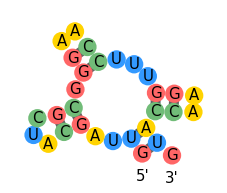

In [21]:
# Crtanje sekundarne strukture
rnk.nacrtaj()

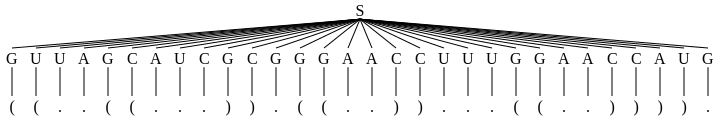

In [22]:
# Drvo kao prost niz baza
rnk

## 3. Gramatika *Nussinov* [⮭]<a id="par:nuss"></a>

[⮭]: #par:toc

Najjednostavnije kontekstno slobodne gramatike za modelovanje strukture *RNK* nadahnute su [algoritmom Nusinov](https://en.wikipedia.org/wiki/Nussinov_algorithm) za maksimizaciju broja uparivanja, objavljenim [1980](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC350273/). Ukoliko su dozvoljena prazna (epsilon) pravila izvođenja, moguća je sledeća kompaktna forma: $S → dSd | SS | s | \epsilon$. Pritom $d$ označava uparene baze, $s$ neuparene, dok $\epsilon$ predstavlja kraj izvođenja. Pravilo $S → SS$ omogućava grananje, a time i postojanje većeg broja zavojnica i petlji.

<img src='../slike/Nussinov.jpg' width='55%'>

Usled ograničenja korišćene [biblioteke](https://www.nltk.org/index.html) za rad sa stohastičkim kontekstno slobodnim [gramatikama](https://www.nltk.org/api/nltk.grammar.html), implementirana je verzija bez praznih pravila. Epsilon izvođenja, naime, onemogućavaju primenu ugrađene klase za [maksimizaciju verovatnoće drveta](https://www.nltk.org/api/nltk.parse.viterbi.html). Konačna gramatika je: $S → dSd$ (uparivanje) $| SS$ (grananje) $| s$ (neuparena baza). Minimalna dužina petlje je jedan, a višeznačnost grananja (odluka gde tačno dolazi do preseka) programatski je razrešena.

In [23]:
# Kontekstno slobodna gramatika Nussinov
class Nussinov(Struktura2D):
    def __init__(self, sekvenca, struktura):
        super().__init__(sekvenca, struktura, 1)
    
    # Obrada neterminala S[i:j]
    def S(self, i, j):
        # Najlevlji (tekući) ribonukleotid
        rn_i = self.sekvenca[i]
        
        # Jedan karakter mora biti neuparena baza
        # na završnoj poziciji: S[i:j] → s
        if i == j:
            return Tree('S', [rn_i])
        
        # Neuparena baza je u suprotnom u petlji,
        # pa je izvođenje S[i:j] → S[i:i] S[i+1:j]
        if self.struktura[i] == '.':
            return Tree('S', [self.S(i, i), self.S(i+1, j)])
        
        # Određivanje uparene baze
        k = self.uparivanje[i]
        rn_k = self.sekvenca[k]
        
        # Potpuno uparivanje znači da je izvođenje
        # u zavojnici: S[i:j] → d S[i+1:j-1] d
        if j == k:
            return Tree('S', [rn_i, self.S(i+1, j-1), rn_k])
        
        # Nepotpuno uparivanje uslovljava grananje,
        # pa je izvođenje S[i:j] → S[i:k] S[k+1:j]
        return Tree('S', [self.S(i, k), self.S(k+1, j)])

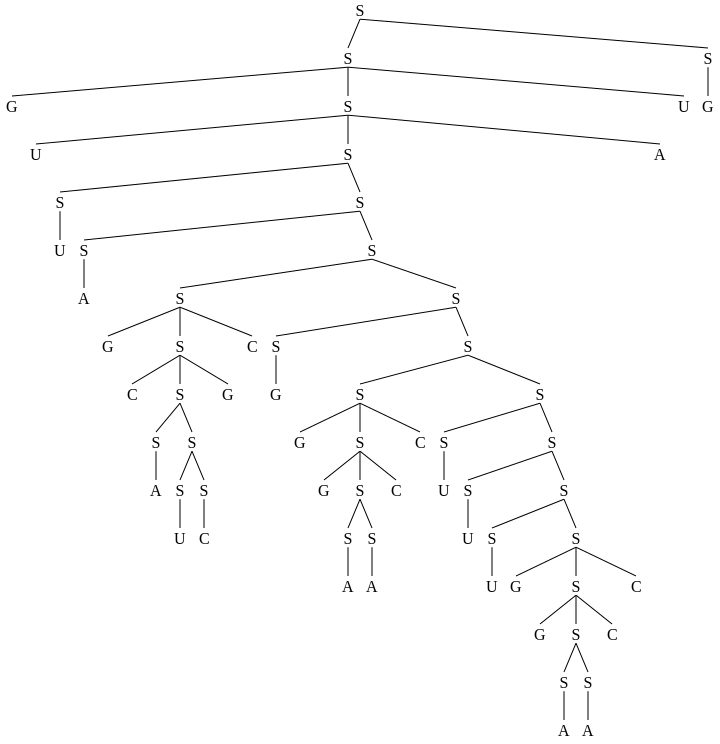

In [24]:
# Enkapsulacija RNK gramatikom Nussinov
Nussinov(sekvenca, struktura)

## 4. Gramatika *KH-99* [⮭]<a id="par:kh99"></a>

[⮭]: #par:toc

Iako su konteksno slobodne gramatike, sasvim prirodno, oslobođene od konteksta, on im se može donekle pridodati pažljivom konstrukcijom pravila izvođenja. Primera radi, pravilo $S → kS$ može se prepisati kao $S → kS^k$. Novi neterminal $S^k$ uvodi se za svaki terminal $k$ i u suštini poznaje svoj kontekst: u pitanju je $S$ koje se nalazi upravo iza simbola $k$. Ovakvo usložnjavanje gramatike naziva se [markovizacija](https://www3.nd.edu/~dchiang/teaching/nlp/2016/notes/chapter13v2.pdf) i predstavlja jedan od načina za povećavanje opisne moći.

Markovizacija, međutim, može proizvesti vrlo složenu gramatiku, a da pritom ne donese srazmerno značajnu dobit. Stoga se često pribegava nešto jednostavnijim metodama za dodavanje konteksta. Jedna takva gramatika za predviđanje sekundarne strukture *RNK* zasnovana je na [algoritmu *KH-99*](https://en.wikipedia.org/wiki/Probabilistic_context-free_grammar), koji su 1999. predstavili [Knudsen i Hejn](https://pubmed.ncbi.nlm.nih.gov/10383470/). Pored poznatih simbola gramatike Nusinov, ova gramatika poznaje i neterminale $L$ i $F$, koji joj upravo pridodaju kontekst.

$$ \large S → LS \scriptsize\text{ (nizanje elemenata) } \large| L \scriptsize\text{ (poslednji element) } $$
$$ \large L → s \scriptsize\text{ (neuparena baza) } \large| dFd \scriptsize\text{ (početak zavojnice) } $$
$$ \large F → dFd \scriptsize\text{ (nastavak zavojnice) } \large| LS \scriptsize\text{ (unutrašnjost zavojnice) } $$

Primetno je da se uparivanja ocenjuju afino: različito ona na početku zavojnice i ona unutar nje. Na taj način uveden je osnovni, ali značajan kontekst, što se ogleda u dobrim rezultatima. Minimalna dužina petlje je dva, sa izvođenjem $F → LS → sS → sL → ss$, a gramatika je jednoznačna za poznatu strukturu. Autori su, inače, 2003. kroz softver [*Pfold*](https://pubmed.ncbi.nlm.nih.gov/12824339/) proširili i poboljšali svoj metod uključivanjem u priču evolutivnih informacija o razmatranim sekvencama.

In [25]:
# Kontekstno slobodna gramatika KH-99
class KH99(Struktura2D):
    def __init__(self, sekvenca, struktura):
        super().__init__(sekvenca, struktura)
    
    # Obrada startnog neterminala S[i:j]
    def S(self, i, j):
        # Jedan karakter mora biti neuparena baza
        # pa je izvođenje S[i:j] → L[i:j]
        if i == j:
            return Tree('S', [self.L(i, j)])
        
        # Neuparena baza je u suprotnom u petlji,
        # pa je izvođenje S[i:j] → L[i:i] S[i+1:j]
        if self.struktura[i] == '.':
            return Tree('S', [self.L(i, i), self.S(i+1, j)])
        
        # Određivanje uparene baze
        k = self.uparivanje[i]
        
        # Potpuno uparivanje znači da je izvođenje
        # u nekoj zavojnici: S[i:j] → L[i:j]
        if j == k:
            return Tree('S', [self.L(i, j)])
        
        # Nepotpuno uparivanje uslovljava grananje,
        # pa je izvođenje S[i:j] → L[i:k] S[k+1:j]
        return Tree('S', [self.L(i, k), self.S(k+1, j)])
    
    # Obrada neterminala petlje L[i:j]
    def L(self, i, j):
        # Najlevlji (tekući) ribonukleotid
        rn_i = self.sekvenca[i]
        
        # Jedan karakter mora biti neuparena baza,
        # pa je izvođenje tipa L[i:j] → s
        if i == j:
            return Tree('L', [rn_i])
        
        # Određivanje uparene baze
        rn_j = self.sekvenca[j]
        
        # Potpuno uparivanje znači da je izvođenje
        # u zavojnici: L[i:j] → d F[i+1:j-1] d
        return Tree('L', [rn_i, self.F(i+1, j-1), rn_j])
    
    # Obrada neterminala zavojnice F[i:j]
    def F(self, i, j):
        # Neuparena baza je u unutrašnjosti heliksa,
        # pa je izvođenje F[i:j] → L[i:i] S[i+1:j]
        if self.struktura[i] == '.':
            return Tree('F', [self.L(i, i), self.S(i+1, j)])

        # Najlevlji (tekući) ribonukleotid
        rn_i = self.sekvenca[i]
        
        # Određivanje uparene baze
        k = self.uparivanje[i]
        rn_k = self.sekvenca[k]
        
        # Potpuno uparivanje znači da je izvođenje
        # u zavojnici: F[i:j] → d F[i+1:j-1] d
        if j == k:
            return Tree('F', [rn_i, self.F(i+1, j-1), rn_k])
        
        # Nepotpuno uparivanje uslovljava grananje,
        # pa je izvođenje F[i:j] → L[i:k] S[k+1:j]
        return Tree('F', [self.L(i, k), self.S(k+1, j)])

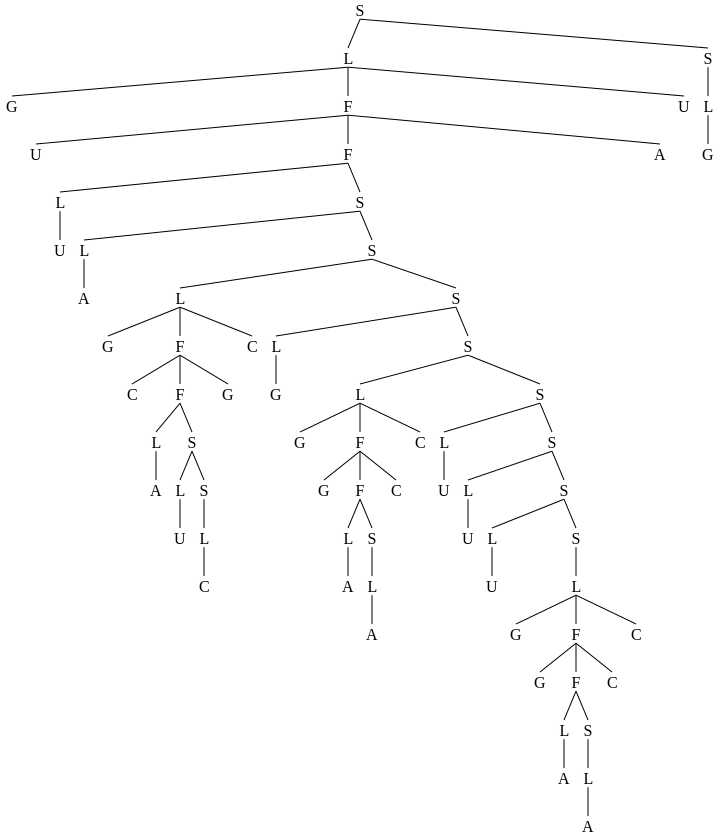

In [26]:
# Enkapsulacija RNK gramatikom KH-99
KH99(sekvenca, struktura)

## 5. Model kovarijacije [⮭]<a id="par:kovar"></a>

[⮭]: #par:toc

Posebnu primenu u modelovanju familija *RNK* i njihove strukture imaju [modeli kovarijacije](https://pubmed.ncbi.nlm.nih.gov/8029015/) (*CM*). Reč je o gramatikama čija pravila izvođenja podrazumevaju postojanje dobro očuvanog skeleta strukture u familiji koja se modeluje. Ovakva pravila, očekivano, nose sa sobom najviše konteksta. Najpoznatija baza kovarijacionih modela sa pridruženim višestrukim poravnanjima, saglasnim strukturama i mnogim metodama analize i vizuelizacije jeste [Rfam](https://rfam.xfam.org/). Sadrži, naravno, i podatke o [*tRNK*](https://rfam.xfam.org/family/RF00005). Dodatan aktuelni resurs za rad i pretragu baza podataka pomoću kovarijansnih modela *tRNK* jeste [*tRNAscan-SE 2.0*](http://lowelab.ucsc.edu/tRNAscan-SE/).

<img src='../slike/R-chie.png' width='60%'>

<img src='../slike/tRNAdb.png' width='62%'>

Već je pomenuto da je sekundarna struktura transportnih *RNK* karakteristična po tome što ima oblik [deteline sa tri lista](https://en.wikipedia.org/wiki/Cloverleaf_model_of_tRNA). Postoje, dakle, tačno tri važne petlje (redom $D$, $Ac$, $T$), tačno četiri zavojnice (redom $Acc$, $D$, $Ac$, $T$) i još neki dodatni elementi ($V$ petlja, $CCA$ rep). Štaviše, mnogi od ovih elemenata su fiksne dužine (npr. $Acc$ drška ima šest ili sedam parova), pa čak i sadržaja (npr. $CCA$ rep, ukoliko postoji), što *tRNK* čini posebno pogodnom za konstrukciju *CM*.

$$ \large G → s \scriptsize\text{ (glava je tačno jedan nukleotid) } $$
$$ \large R → Gcca \scriptsize\text{ (glava i $CCA$ rep) } \large| G \scriptsize\text{ (samo glava) } $$
$$ \large S → GZ^SR \scriptsize\text{ (glava, zavojnica i rep) } \large| Z^SR \scriptsize\text{ (zavojnica i rep) } $$
$$ \large Z^S → dZ^Sd \scriptsize\text{ (uparivanje) } \large| GZ^SG \scriptsize\text{ (promašaj) } \large| GGZ^UZ^ULZ^U \scriptsize\text{ (unutrašnjost) } $$
$$ \large Z^U → dZ^Ud \scriptsize\text{ (uparivanje) } \large| GZ^UG \scriptsize\text{ (promašaj) } \large| L \scriptsize\text{ (unutrašnjost) } $$
$$ \large L → GL \scriptsize\text{ (nizanje baza) } \large| GG \scriptsize\text{ (dve baze) } $$

Ovakva gramatika nije pravi kovarijacioni model po definiciji, ali ipak prilično precizno oslikava strukturu transportne *RNK*. Prednost joj je što za obučavanje ne zahteva poznavanje višestrukog poravnanja trening skupa, mada je kao posledica toga nešto manje uspešna. Jednoznačna je za poznatu strukturu, uz napomenu da zahteva poznavanje cele sekvence u svakom trenutku. Minimalna dužina petlje je dva, sa izvođenjem $Z^U → L → GG → sG → ss$.

In [27]:
# Model kovarijacije tRNK
class CM(Struktura2D):
    def __init__(self, sekvenca, struktura):
        super().__init__(sekvenca, struktura)
    
    # Obrada startnog neterminala S[i:j]
    def S(self, i, j):
        # Broj najdešnjih neuparenih baza
        n = j - self.struktura.rfind(')')
        
        # Određivanje granice zavojnice i repa
        k = j - n + int(n == 2 or n == 5)
        
        # Broj najlevljih neuparenih baza
        m = self.struktura.find('(')
        
        # Ako je višak neuparenih jednak sa obe strane, nema
        # glave, pa je izvođenje S[i:j] → Z^S[i:k] R[k+1:j]
        if m == int(n == 2 or n == 5):
            return Tree('S', [self.ZS(i, k), self.R(k+1, j)])
        # U suprotnom postoji glava, strogo jednočlana, pa je
        # izvođenje tipa S[i:j] → G[i:i] Z^S[i+1:k] R[k+1:j]
        else:
            return Tree('S', [self.G(i, i), self.ZS(i+1, k), self.R(k+1, j)])
    
    # Obrada neterminala glave G[i:j]
    def G(self, i, j):
        # Najlevlji (tekući) ribonukleotid
        rn_i = self.sekvenca[i]
        
        # Izvođenje je uvek tipa G[i:j] → s
        return Tree('G', [rn_i])
    
    # Obrada neterminala repa R[i:j]
    def R(self, i, j):
        # Jedan karakter mora biti glava,
        # pa je izvođenje R[i:j] → G[i:j]
        if i == j:
            return Tree('R', [self.G(i, j)])
        
        # U suprotnom je CCA rep, pa je izvođenje
        # tipa R[i:j] → G[i:i] 'C' 'C' 'A'
        return Tree('R', [self.G(i, i), 'C', 'C', 'A'])
    
    # Određivanje kraja zavojnice
    def zavojnica(self, i, j):
        # Prolazak kroz sve indekse
        for l in range(i, j):
            # Odabir prvog uparivanja
            if self.struktura[l] == '(':
                k = self.uparivanje[l]
                
                # Dodavanje broja neuparenih
                return k + l - i
    
    # Obrada neterminala spoljašnje
    # zavojnice (drške) Z^S[i:j]
    def ZS(self, i, j):
        # Zavojnica se potencijalno nastavlja
        if self.struktura[i] == '(':
            # Granični (tekući) ribonukleotidi
            rn_i = self.sekvenca[i]
            rn_j = self.sekvenca[j]
            
            # Izvođenje je Z^S[i:j] → d Z^S[i+1:j-1] d
            return Tree('Z^S', [rn_i, self.ZS(i+1, j-1), rn_j])
        
        # Zavojnica potencijalno ima prekid, pa je izvođenje
        # tipa Z^S[i:j] → G[i:i] Z^S[i+1:j-1] G[j:j]
        if self.struktura[i+1] == '(':
            return Tree('Z^S', [self.G(i, i), self.ZS(i+1, j-1), self.G(j, j)])
        
        # U suprotom se stiglo do unutrašnjosti, koja ima složeno izvođenje tipa
        # Z^S[i:j] → G[i:i] G[i+1:i+1] Z^U[i+2:k] Z^U[k+1:l] L[l+1:m-1] Z^U[m:j]
        
        # Određivanje slobodnih baza
        g1 = self.G(i, i)
        g2 = self.G(i+1, i+1)
        
        # Određivanje prve zavojnice
        k = self.zavojnica(i+2, j)
        z1 = self.ZU(i+2, k)
        
        # Određivanje druge zavojnice
        l = self.zavojnica(k+1, j)
        z2 = self.ZU(k+1, l)
        
        # Određivanje početka treće zavojnice
        for m in range(l+2, j):
            if self.struktura[m] == '(':
                break
        
        # Pomeranje početka ako ima neuparenih
        m -= j - self.uparivanje[m]
        
        # Određivanje treće zavojnice
        z3 = self.ZU(m, j)
        
        # Određivanje varijabilne petlje
        l = self.L(l+1, m-1)
        
        # Primena izvođenja unutrašnjosti, ali u prilagođenoj binarnoj formi:
        # Z^S[i:j] → G[i:i] Z^S1[i+1:j], Z^S1[i+1:j] → G[i+1:i+1] Z^S2[i+2:j],
        # Z^S2[i+2:j] → Z^U[i+2:k] Z^S3[k+1:j], Z^S3[k+1:j] → Z^U[k+1:l] Z^S4[l+1:j],
        # Z^S4[l+1:j] → L[l+1:m-1] Z^U[m:j], koja je neophodna zbog algoritma
        return Tree('Z^S', [g1, Tree('Z^S1', [g2, Tree('Z^S2', [z1,
                    Tree('Z^S3', [z2, Tree('Z^S4', [l, z3])])])])])
    
    # Obrada neterminala unutrašnjih
    # zavojnica (drški) Z^U[i:j]
    def ZU(self, i, j):
        # Zavojnica se potencijalno nastavlja
        if self.struktura[i] == '(':
            # Granični (tekući) ribonukleotidi
            rn_i = self.sekvenca[i]
            rn_j = self.sekvenca[j]
            
            # Izvođenje je Z^U[i:j] → d Z^U[i+1:j-1] d
            return Tree('Z^U', [rn_i, self.ZU(i+1, j-1), rn_j])
        
        # Zavojnica potencijalno ima prekid, pa je izvođenje
        # tipa Z^U[i:j] → G[i:i] Z^U[i+1:j-1] G[j:j]
        if self.struktura[i+1] == '(':
            return Tree('Z^U', [self.G(i, i), self.ZU(i+1, j-1), self.G(j, j)])
        
        # U suprotnom se stiglo do petlje, pa
        # je izvođenje tipa Z^U[i:j] → L[i:j]
        return Tree('Z^U', [self.L(i, j)])
    
    # Obrada neterminala petlje L[i:j]
    def L(self, i, j):
        # Dva karaktera moraju biti bazni slučaj,
        # pa je izvođenje L[i:j] → G[i:i] G[j:j]
        if i + 1 == j:
            return Tree('L', [self.G(i, i), self.G(j, j)])
        
        # U suprotno se baze nižu, tako da je
        # izvođenje tipa L[i:j] → G[i:i] L[i+1:j]
        return Tree('L', [self.G(i, i), self.L(i+1, j)])

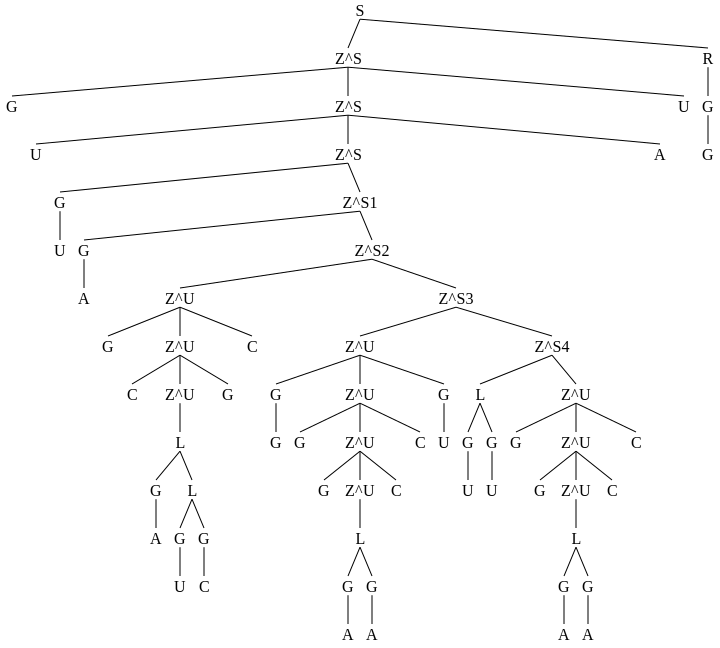

In [28]:
# Enkapsulacija RNK modelom kovarijacije
CM(sekvenca, struktura)

## 6. Baza podataka *tRNAdb* [⮭]<a id="par:trnadb"></a>

[⮭]: #par:toc

Skup podataka preuzet je iz baze [*tRNAdb*](http://trna.bioinf.uni-leipzig.de/DataOutput/), koja sadrži $623$ različite anotirane *tRNK* sekvence. Konkretno, preuzete su $474$ sekvence koje ne potiču iz [mitohondrija](https://en.wikipedia.org/wiki/Mitochondrion) ili [plastida](https://en.wikipedia.org/wiki/Plastid). Prvi korak pripreme podataka jeste obrada karekteristično formatiranog zaglavlja, koje sadrži podatke o organizmu i antikodonu.

In [29]:
# Priprema zaglavlja iz baze
def pripremi_zaglavlje(zaglavlje):
    # Podela zaglavlja po separatoru
    if isinstance(zaglavlje, str):
        zaglavlje = zaglavlje.split('|')
        
        # Provera da li je sve u redu
        if len(zaglavlje) != 5:
            zaglavlje = None
    else: zaglavlje = None
    
    # Skladištenje podataka u rečniku
    return {'id': zaglavlje[0][1:] if zaglavlje else None,
            'vrsta': zaglavlje[1] if zaglavlje else None,
            'id_vrste': int(zaglavlje[2]) if zaglavlje else None,
            'aminokiselina': zaglavlje[3] if zaglavlje else None,
            'antikodon': zaglavlje[4] if zaglavlje else None}

In [30]:
# Korektno zaglavlje
pripremi_zaglavlje('>tdbR00000589|Aeropyrum_pernix|56636|Arg|UCU')

{'id': 'tdbR00000589',
 'vrsta': 'Aeropyrum_pernix',
 'id_vrste': 56636,
 'aminokiselina': 'Arg',
 'antikodon': 'UCU'}

In [31]:
# Nekorektno zaglavlje: nije niska
pripremi_zaglavlje(None)

{'id': None,
 'vrsta': None,
 'id_vrste': None,
 'aminokiselina': None,
 'antikodon': None}

Klasa koja opisuje *tRNK* pored sekvence i strukture skladišti i opisno zaglavlje, kao i stabla izvođenja prema svim definisanim gramatikama.

In [32]:
# Transportna ribonukleinska kiselina
class tRNK(Struktura2D):
    def __init__(self, sekvenca, struktura, zaglavlje=None):
        super().__init__(sekvenca, struktura)
        
        # Priprema zaglavlja iz baze
        self.pripremi_zaglavlje(zaglavlje)
        
        # Određivanje svih stabala izvođenja
        self.odredi_stabla()
    
    # Priprema zaglavlja iz baze
    def pripremi_zaglavlje(self, zaglavlje):
        # Čuvanje svih podataka iz zaglavlja
        for atribut, vrednost in pripremi_zaglavlje(zaglavlje).items():
            setattr(self, atribut, vrednost)
        
        # Čuvanje zaglavlja u originalu
        self.zaglavlje = zaglavlje
    
    # Određivanje svih stabala izvođenja
    def odredi_stabla(self):
        # Stablo gramatike Nussinov
        self.nussinov = Nussinov(self.sekvenca, self.struktura)
        
        # Stablo gramatike KH-99
        self.kh99 = KH99(self.sekvenca, self.struktura)
        
        # Stablo modela kovarijacije
        self.cm = CM(self.sekvenca, self.struktura)

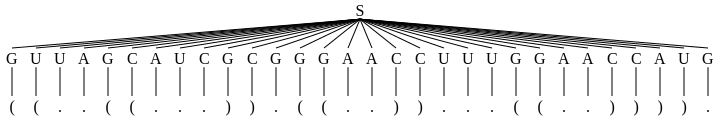

In [33]:
# Enkapsulacija RNK svim modelima
tRNK(sekvenca, struktura)

Neophodno je filtrirati neke u biti nekorektne sekvence koje imaju nepoznate nukleobaze (tačke i podvlake) ili neočekivana uparivanja poput $A-C$.

In [34]:
# Provera da li je unos u bazi upotrebljiv
def proveri_unos(sekvenca, zaglavlje=None):
    return '.' not in sekvenca and '_' not in sekvenca and \
      (zaglavlje is None or ('tdbR00000205' not in zaglavlje
                        and 'tdbR00000251' not in zaglavlje))

In [35]:
# Upotrebljiv unos u bazi
proveri_unos('GC')

True

In [36]:
# Nepotrebljiv unos u bazi
proveri_unos('G.')

False

Podaci se čitaju iz preuzete datoteke *tRNAdb.fst*, koja sadrži spisak svih *tRNK* u formatu zaglavlje-sekvenca-struktura, pri čemu su svi podaci razdvojeni novim redom. Kako se o svakoj *tRNK* čuvaju tačno tri informacije, ova datoteka, dakle, ukupno ima $3 \cdot 474 = 1422$ reda koja treba obraditi.

In [37]:
# Čitanje podataka o tRNK
def podaci(fst):
    with open(fst, encoding='utf-8') as f:
        fst = f.read().split()
    
    # Broj tRNK u skupu podataka
    n = len(fst) // 3
    
    # Prolazak kroz sve tRNK
    for i in range(n):
        zaglavlje = fst[3*i]
        sekvenca = fst[3*i + 1]
        struktura = fst[3*i + 2]
        
        # Provera i konstrukcija tRNK
        if proveri_unos(sekvenca, zaglavlje):
            yield tRNK(sekvenca, struktura, zaglavlje)

Nakon filtriranja podataka, u skupu ostaju $432$ sasvim korektne sekvence, koje će i biti korišćene nadalje u obučavanju i proveri implementiranih gramatika.

In [38]:
# Učitavanje podataka iz tRNAdb
rnk = [*podaci('../podaci/tRNAdb.fst')]

# Broj uspešno učitanih sekvenci
len(rnk)

432

Nad podacima je moguće uraditi razne eksploratorne analize. Primera radi, može se primetiti da je ubedljivo najčešće uparivanje $G-C$. Na drugom mestu je obrnuti par $C-G$, dok je dva do tri puta manje parova $A-U$ i $U-A$. Postoji i određeni nezanemarljivi broj nekanonskih parova $U-G$ i $G-U$.

In [39]:
# Globalna uparenost na nivou skupa
{rn_i: {rn_j: sum(r.uparenost[rn_i][rn_j] for r in rnk)
        for rn_j in azbuka} for rn_i in azbuka}

{'U': {'U': 0, 'C': 0, 'G': 190, 'A': 1206},
 'C': {'U': 0, 'C': 0, 'G': 2497, 'A': 0},
 'G': {'U': 370, 'C': 3631, 'G': 0, 'A': 0},
 'A': {'U': 1066, 'C': 0, 'G': 0, 'A': 0}}

## 7. Konstrukcija modela [⮭]<a id="par:konstr"></a>

[⮭]: #par:toc

Modeli se konstruišu tako što se gramatika indukuje na osnovu skupa za obučavanje. U tom skupu se nalazi deo *tRNK* sa pridruženim stablima izvođenja. Iz svakog stabla moguće je izvući niz primenjenih pravila izvođenja, na osnovu kojih je nadalje moguće odrediti verovatnoće izvođenja u gramatici. Nakon obučavanja, gramatika može poslužiti za predviđanje struktura, i to pomoću [Viterbijevog](https://en.wikipedia.org/wiki/Viterbi_algorithm) parsera, koji određuje najverovatnije ([*CYK*](https://en.wikipedia.org/wiki/CYK_algorithm)) stablo izvođenja.

In [40]:
# Biblioteka za rad sa PCFG
from nltk import induce_pcfg, Nonterminal, ViterbiParser

# Stohastička kontekstno slobodna gramatika
class Model:
    def __init__(self, trening):
        # Pravljenje i obučavanje gramatike
        self.gramatika = self.obuči(trening)
        
        # Sortiranje pravila radi lepšeg prikaza
        self.gramatika.productions().sort(
            key=lambda p: (p.lhs(), len(p.rhs()), p.prob()), reverse=True)
        
        # Pravljenje parsera nad gramatikom
        self.parser = ViterbiParser(self.gramatika)
    
    # Prikaz gramatike u konzoli
    def _ipython_display_(self):
        print(self.gramatika)
    
    # Pravljenje i obučavanje gramatike
    def obuči(self, trening):
        # Izdvajanje svih stabala izvođenja
        trening = map(self.drvo, trening)
        
        # Izdvajanje svih pravila izvođenja
        pravila = [p for t in trening for p in t.productions()]
        
        # Indukcija gramatike nad pravilima
        return induce_pcfg(Nonterminal('S'), pravila)
    
    # Pravljenje strukture na osnovu drveta
    @staticmethod
    def od_drveta(*drvo):
        # Ukoliko je list, neuparena je baza
        if isinstance(drvo[0], str):
            if len(drvo) == 1:
                return '.'
            
            # Tročlano izvođenje je uparivanje
            if len(drvo) == 3:
                return '(' + Model.od_drveta(*drvo[1]) + ')'
        
        # Sva ostala izvođenja se razlažu
        return ''.join(Model.od_drveta(*d) for d in drvo)
    
    # Predviđanje jedne strukture
    def predvidi(self, test):
        # Izdvajanje sekvence testne RNK
        sekvenca = test.sekvenca
        
        # Formiranje stabla izvođenja
        stablo = self.parser.parse_one(sekvenca)
        
        # Formiranje strukture prema stablu
        return Model.od_drveta(*stablo)

Na prvom mestu, gramatika tipa Nusinov može se obučiti pomoću skupa za trening, pri čemu se samostalno izračunavaju verovatnoće primene pravila.

In [41]:
# Obučena gramatika Nussinov
class Nussinov_M(Model):
    def __init__(self, trening):
        super().__init__(trening)
    
    # Dohvatanje odgovarajućeg stabla
    @staticmethod
    def drvo(instanca):
        return instanca.nussinov.drvo

In [42]:
# Biblioteka za podelu skupa podataka
from sklearn.model_selection import train_test_split

# Podela na skupove za test i trening
trening, test = train_test_split(rnk, random_state=0)

# Obučena gramatika Nussinov
nussinov = Nussinov_M(trening)

# Prikaz instancirane gramatike
nussinov

Grammar with 11 productions (start state = S)
    S -> 'G' S 'C' [0.0905911]
    S -> 'C' S 'G' [0.0617045]
    S -> 'U' S 'A' [0.0303525]
    S -> 'A' S 'U' [0.0269874]
    S -> 'G' S 'U' [0.00922903]
    S -> 'U' S 'G' [0.00496435]
    S -> S S [0.382688]
    S -> 'A' [0.112048]
    S -> 'U' [0.110515]
    S -> 'G' [0.0900913]
    S -> 'C' [0.0808289]


I gramatika tipa *KH-99* može se obučiti pomoću skupa za trening, pri čemu se takođe samostalno izračunavaju pravila izvođenja i verovatnoće primene.

In [43]:
# Obučena gramatika KH-99
class KH99_M(Model):
    def __init__(self, trening):
        super().__init__(trening)
    
    # Dohvatanje odgovarajućeg stabla
    @staticmethod
    def drvo(instanca):
        return instanca.kh99.drvo

In [44]:
# Obučena gramatika KH-99
kh99 = KH99_M(trening)

# Prikaz instancirane gramatike
kh99

Grammar with 19 productions (start state = S)
    S -> L S [0.860373]
    S -> L [0.139627]
    L -> 'G' F 'C' [0.050552]
    L -> 'C' F 'G' [0.0192615]
    L -> 'G' F 'U' [0.0124096]
    L -> 'U' F 'A' [0.00989722]
    L -> 'A' F 'U' [0.00738485]
    L -> 'U' F 'G' [0.00137038]
    L -> 'A' [0.256033]
    L -> 'U' [0.252531]
    L -> 'G' [0.205862]
    L -> 'C' [0.184697]
    F -> 'G' F 'C' [0.305895]
    F -> 'C' F 'G' [0.238017]
    F -> 'U' F 'A' [0.116255]
    F -> 'A' F 'U' [0.106133]
    F -> 'U' F 'G' [0.0194999]
    F -> 'G' F 'U' [0.0169693]
    F -> L S [0.197231]


Šta je važilo za gramatiku tipa Nusinov i *KH-99*, važi i za kovarijacioni model: i on se obučava na osnovu izvođenja primenjenih u skupu za trening.

In [45]:
# Obučeni model kovarijacije
class CM_M(Model):
    def __init__(self, trening):
        super().__init__(trening)
    
    # Dohvatanje odgovarajućeg stabla
    @staticmethod
    def drvo(instanca):
        return instanca.cm.drvo

In [46]:
# Obučeni model kovarijacije
cm = CM_M(trening)

# Prikaz instancirane gramatike
cm

Grammar with 30 productions (start state = S)
    Z^U -> 'G' Z^U 'C' [0.315679]
    Z^U -> 'C' Z^U 'G' [0.220624]
    Z^U -> 'U' Z^U 'A' [0.108909]
    Z^U -> 'A' Z^U 'U' [0.0864609]
    Z^U -> G Z^U G [0.0462995]
    Z^U -> 'G' Z^U 'U' [0.0349]
    Z^U -> 'U' Z^U 'G' [0.0166608]
    Z^U -> L [0.170467]
    Z^S4 -> L Z^U [1.0]
    Z^S3 -> Z^U Z^S4 [1.0]
    Z^S2 -> Z^U Z^S3 [1.0]
    Z^S1 -> G Z^S2 [1.0]
    Z^S -> 'G' Z^S 'C' [0.353146]
    Z^S -> 'C' Z^S 'G' [0.229255]
    Z^S -> 'A' Z^S 'U' [0.121961]
    Z^S -> 'U' Z^S 'A' [0.110768]
    Z^S -> 'G' Z^S 'U' [0.0301042]
    Z^S -> 'U' Z^S 'G' [0.0208414]
    Z^S -> G Z^S G [0.00887688]
    Z^S -> G Z^S1 [0.125048]
    S -> G Z^S R [0.037037]
    S -> Z^S R [0.962963]
    R -> G 'C' 'C' 'A' [0.978395]
    R -> G [0.0216049]
    L -> G L [0.838424]
    L -> G G [0.161576]
    G -> 'U' [0.305379]
    G -> 'A' [0.280368]
    G -> 'G' [0.249011]
    G -> 'C' [0.165241]


## 8. Poređenje modela [⮭]<a id="par:poredj"></a>

[⮭]: #par:toc

Nakon što su modeli instacirani i obučeni, red je oceniti njihovu uspešnost. Za početak, napisana je klasa koja enkapsulira sva predviđanja. Ona predviđa strukturu *tRNK* iz skupa za testiranje na osnovu tri obučena modela, skladišti ih na disku, a čuva i njihove grafičke prikaze za potrebe vizuelne evaluacije.

In [47]:
# Biblioteka za JSON format
import json

# Biblioteka za fajl sistem
import os, os.path

# Biblioteka za crtanje
from matplotlib.pyplot import close, subplots

# Sigurno otvaranje fajla
def fopen(fajl):
    # Pravljenje potrebnih direktorijuma
    os.makedirs(os.path.dirname(fajl), exist_ok=True)
    
    # Otvaranje fajla za pisanje
    return open(fajl, 'w')

# Enkapsulirana sva predviđanja
class tRNK_M:
    def __init__(self, rnk):
        # Putanja na fajl sistemu
        putanja = f'../predikcije/{rnk.id}.json'
        
        try:
            # Pokušaj čitanja sa lokala
            with open(putanja) as f:
                rnk = json.load(f)

            # Upisivanje vrednosti
            for prop in rnk:
                setattr(self, prop, rnk[prop])
        except:
            # Osnovni podaci o RNK
            self.id = rnk.id
            self.zaglavlje = rnk.zaglavlje
            self.sekvenca = rnk.sekvenca
            self.struktura = rnk.struktura
            
            # Predviđene strukture
            self.nussinov = nussinov.predvidi(rnk)
            self.kh99 = kh99.predvidi(rnk)
            self.cm = cm.predvidi(rnk)
            
            # Upisivanje na lokal za ubuduće
            with fopen(putanja) as f:
                json.dump({'id': self.id,
                           'zaglavlje': self.zaglavlje,
                           'sekvenca': self.sekvenca,
                           'struktura': self.struktura,
                           'nussinov': self.nussinov,
                           'kh99': self.kh99,
                           'cm': self.cm}, f)
            
            # Čuvanje slike strukture
            self.sačuvaj_sliku()
    
    # Prikaz predviđanja u konzoli
    def _ipython_display_(self):
        self.uporedi_strukture()
    
    # Čuvanje slike strukture
    def sačuvaj_sliku(self):
        # Dohvatanje pripremljene slike
        fig = self.uporedi_strukture()
        
        # Osiguravanje da postoji direktorijum
        putanja = f'../poredjenje/{self.id}'
        os.makedirs(os.path.dirname(putanja), exist_ok=True)
        
        # Čuvanje pripremljene slike
        fig.savefig(putanja)
        
        # Zatvaranje da ne curi memorija
        close(fig)
    
    # Poređenje predviđenih struktura
    def uporedi_strukture(self):
        # Pravljenje grafika za poređenje
        fig, axs = subplots(2, 2, figsize=(17, 14))

        # Naslovljavanje grafika sekvencom
        fig.suptitle('\n'.join((self.zaglavlje, self.sekvenca, '')), fontsize=14)

        # Ucrtavanje stvarne strukture
        axs[0, 0].set_title('\n'.join(('Stvarna struktura', self.struktura)))
        draw_struct(self.sekvenca, self.struktura, ax=axs[0, 0])

        # Ucrtavanje Nussinov strukture
        axs[0, 1].set_title('\n'.join(('Nussinov struktura', self.nussinov)))
        draw_struct(self.sekvenca, self.nussinov, ax=axs[0, 1])
        
        # Ucrtavanje KH-99 strukture
        axs[1, 0].set_title('\n'.join(('KH-99 struktura', self.kh99)))
        draw_struct(self.sekvenca, self.kh99, ax=axs[1, 0])
        
        # Ucrtavanje CM strukture
        axs[1, 1].set_title('\n'.join(('CM struktura', self.cm)))
        draw_struct(self.sekvenca, self.cm, ax=axs[1, 1])
        
        # Sređivanje grafikona
        fig.tight_layout()
        
        # Vraćanje sređenog grafikona
        return fig

In [48]:
# Predviđanje strukture nad test skupom
test = [*map(tRNK_M, test)]

Intuitivan način provere modela jeste poređenje crteža struktura: vizuelno sličnija predviđanja su i suštinski bliža stvarnoj strukturi. Gramatika tipa Nusinov maksimizuje broj uparivanja, što je konceptualno opravdano, ali ipak ne odgovara stvarnosti. Gramatika *KH-99* je ozbiljnija: uspešno predviđa opštu formu uvijanja, ali ipak nedovoljno tačno. Očekivano, model kovarijacije ponaša se najbolje. Čuva najviše podataka o kontekstu, te ima najveći broj parametara.

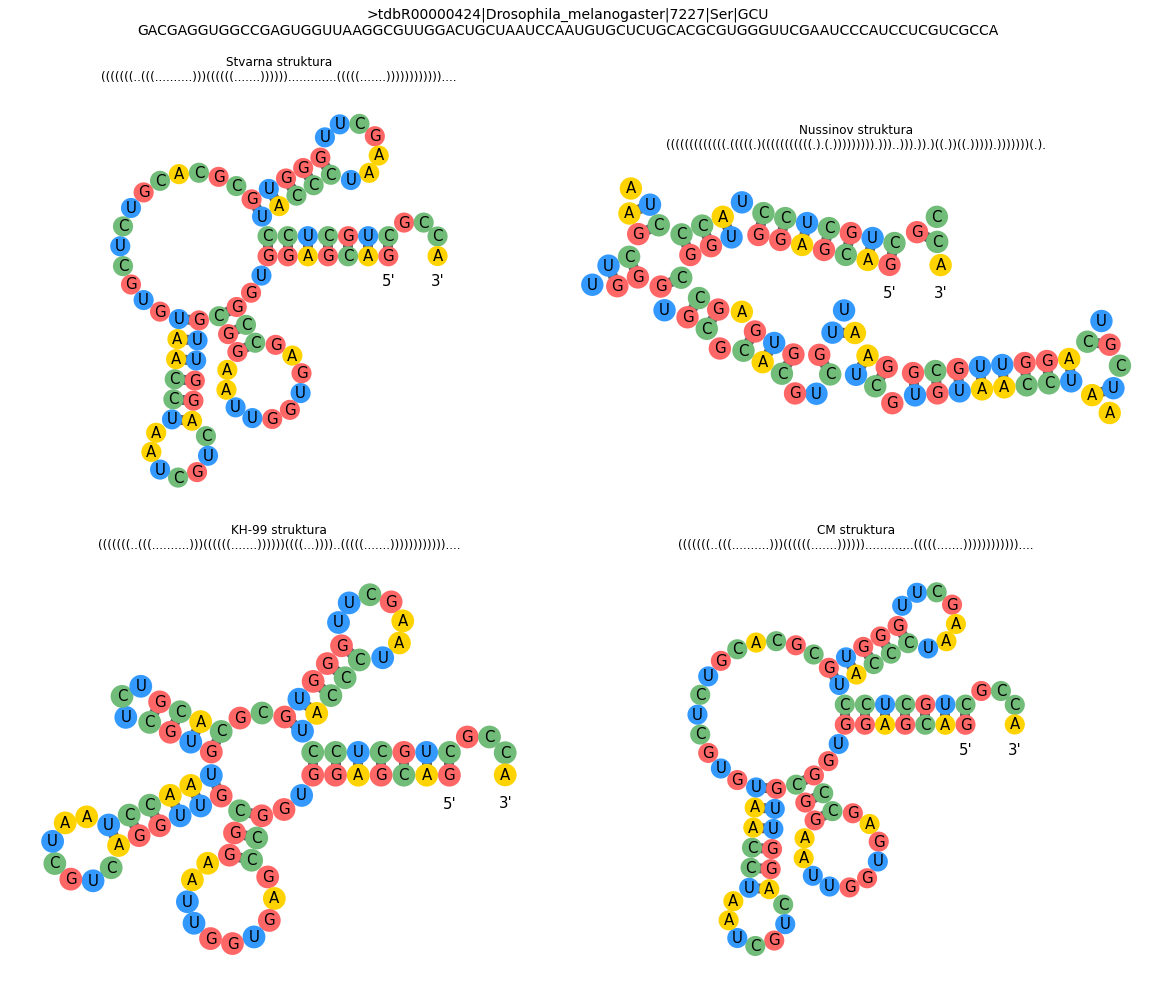

In [49]:
# Grafički prikaz uspešnosti modela
test[79]